# Setup/Imports

In [96]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

RSEED = 75

# Loading the data/EDA

In [2]:
df = pd.read_csv('data/kickstarter_projects.csv', parse_dates=['Deadline', 'Launched'])
df.head()
df.columns = df.columns.str.lower()
df.head()

,id,name,category,subcategory,country,launched,deadline,goal,pledged,backers,state
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [3]:
# Create a feature that contains the length of the name of the campaign and drop the name
df['name_length'] = df['name'].str.len()
df = df.drop(['name', 'id'], axis=1)
df.head()

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,59
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,30
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,19
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,28
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,10


In [4]:
# Create a feature with timespan between launch and deadline
df['campaign_duration'] = (df['deadline']-df['launched']).dt.days
df.head()


,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,59,39
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,30,87
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,19,8
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,28,79
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,10,28


In [5]:
# Create feature with the month of the launch and deadline
df['launched_month'] = df['launched'].dt.month
df['deadline_month'] = df['deadline'].dt.month
df.sample(5)

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month
73647,Film & Video,Narrative Film,United Kingdom,2012-10-31 11:30:44,2012-12-03,19211,9766,69,Failed,22,32,10,12
44233,Design,Product Design,United States,2012-02-28 13:17:57,2012-03-29,25000,34490,143,Successful,47,29,2,3
28787,Music,Indie Rock,United States,2011-09-01 01:29:15,2011-10-16,8000,35,3,Failed,38,44,9,10
352509,Publishing,Fiction,United States,2017-07-19 03:52:50,2017-09-17,27000,0,0,Failed,44,59,7,9
269469,Music,Electronic Music,United States,2016-01-23 22:22:14,2016-03-23,2000,1,1,Failed,44,59,1,3


In [6]:
# Create a feature with the quarter of the launch and dealine
df['launched_quarter'] = (df['launched_month'] - 1) // 3 + 1
df['deadline_quarter'] = (df['deadline_month'] - 1) // 3 + 1
df.sample(5)

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
366793,Fashion,Fashion,Canada,2017-10-28 01:13:37,2017-12-27,11962,654,5,Failed,22,59,10,12,4,4
242191,Games,Tabletop Games,Australia,2015-08-16 03:34:51,2015-09-20,8419,18607,308,Successful,40,34,8,9,3,3
219986,Music,Faith,United States,2015-04-30 21:46:10,2015-05-30,3500,3677,42,Successful,58,29,4,5,2,2
357190,Fashion,Accessories,United Kingdom,2017-08-22 13:05:33,2017-09-21,373,85,3,Failed,22,29,8,9,3,3
255766,Food,Food,United Kingdom,2015-10-28 09:45:29,2015-11-28,28199,0,0,Canceled,23,30,10,11,4,4


In [7]:
df['state'].value_counts()
#df = df.drop[df['state'] == 'Live'],axis=0)

df.drop(df[df['state'] == 'Live'].index, inplace=True)

In [8]:
# Check what kind of states we have 
df['state'].value_counts()


state
Failed        197611
Successful    133851
Canceled       38751
Suspended       1842
Name: count, dtype: int64

In [9]:
# Include the state 'canceled' and 'suspendend' in the 'failed' state and transform 'failed' to 0 and 'successful' to 1

df['state'] = df['state'].replace(['Failed', 'Canceled', 'Suspended'], 0) # Failed = 0
df['state'] = df['state'].replace('Successful', 1) #Successfull = 1

df.head()

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,0,59,39,4,5,2,2
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,0,30,87,4,7,2,3
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,1,19,8,4,5,2,2
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,1,28,79,4,7,2,3
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,0,10,28,4,5,2,2


<Axes: xlabel='state', ylabel='count'>

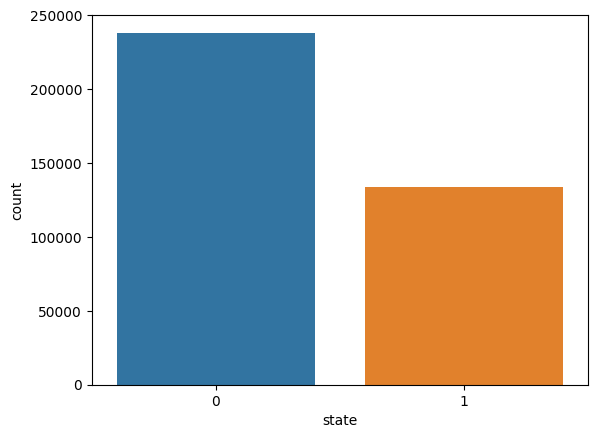

In [10]:
sns.countplot(data=df, x='state')

In [11]:
df.describe()

,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
count,372055,372055,3.720550e+05,3.720550e+05,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000,372055.000000
mean,2014-09-17 16:56:47.029393152,2014-10-21 07:34:21.440378624,4.573831e+04,9.145513e+03,106.980393,0.359761,34.873191,33.175141,6.428238,6.766121,2.485866,2.580428
min,2009-04-21 21:02:48,2009-05-03 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2013-04-24 20:46:51,2013-05-27 00:00:00,2.000000e+03,3.100000e+01,2.000000,0.000000,21.000000,29.000000,4.000000,4.000000,2.000000,2.000000
50%,2014-11-24 21:12:56,2014-12-30 00:00:00,5.500000e+03,6.280000e+02,12.000000,0.000000,34.000000,29.000000,6.000000,7.000000,2.000000,3.000000
75%,2016-03-16 05:30:40.500000,2016-04-19 00:00:00,1.600000e+04,4.066000e+03,57.000000,1.000000,49.000000,36.000000,9.000000,10.000000,3.000000,4.000000
max,2018-01-02 03:05:10,2018-02-24 00:00:00,1.663614e+08,2.033899e+07,219382.000000,1.000000,96.000000,91.000000,12.000000,12.000000,4.000000,4.000000
std,NaN,NaN,1.151699e+06,9.162231e+04,914.532666,0.479931,15.942159,12.793434,3.307690,3.318672,1.094263,1.085238


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372055 entries, 0 to 374823
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           372055 non-null  object        
 1   subcategory        372055 non-null  object        
 2   country            372055 non-null  object        
 3   launched           372055 non-null  datetime64[ns]
 4   deadline           372055 non-null  datetime64[ns]
 5   goal               372055 non-null  int64         
 6   pledged            372055 non-null  int64         
 7   backers            372055 non-null  int64         
 8   state              372055 non-null  int64         
 9   name_length        372055 non-null  int64         
 10  campaign_duration  372055 non-null  int64         
 11  launched_month     372055 non-null  int32         
 12  deadline_month     372055 non-null  int32         
 13  launched_quarter   372055 non-null  int32        

In [13]:
list_of_countries = pd.DataFrame(df['country'].value_counts(normalize=True)*100)
list_of_countries

,proportion
country,
United States,78.181452
United Kingdom,8.975017
Canada,3.930602
Australia,2.088132
Germany,1.100912
France,0.775961
Netherlands,0.761447
Italy,0.753114
Spain,0.597761


In [14]:

other_countries = list_of_countries[list_of_countries['proportion'] < 1]

In [15]:
other_countries

,proportion
country,
France,0.775961
Netherlands,0.761447
Italy,0.753114
Spain,0.597761
Sweden,0.466866
Mexico,0.442139
New Zealand,0.385964
Denmark,0.294849
Ireland,0.215022


In [16]:
df['country'].replace(other_countries.index, 'other', inplace=True)
df['country'].value_counts()

country
United States     290878
United Kingdom     33392
other              21296
Canada             14624
Australia           7769
Germany             4096
Name: count, dtype: int64

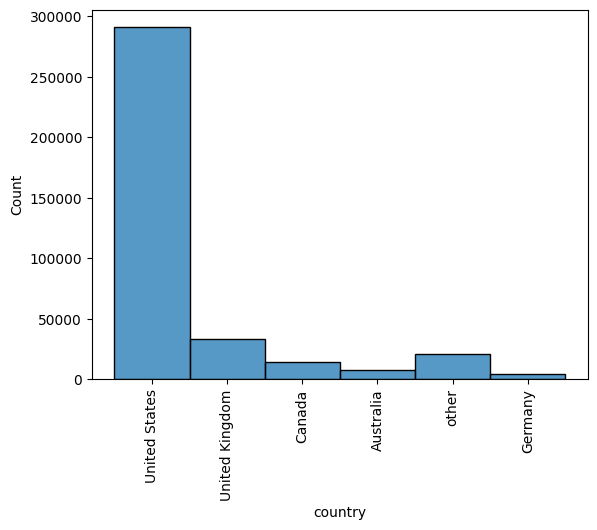

In [17]:
ax = sns.histplot(data=df['country'])
ax.tick_params(axis='x', rotation=90)

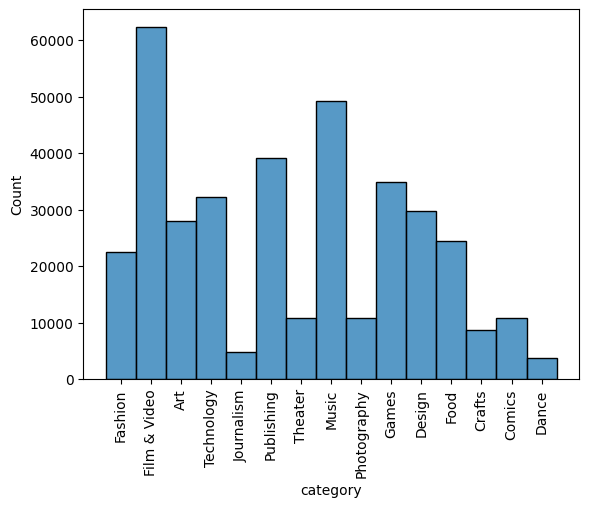

In [18]:
ax = sns.histplot(data=df['category'])
ax.tick_params(axis='x', rotation=90)

In [19]:
df['category'].value_counts(normalize=True)*100

category
Film & Video    16.761500
Music           13.236753
Publishing      10.503555
Games            9.390547
Technology       8.650603
Design           7.998817
Art              7.514212
Food             6.562471
Fashion          6.064157
Theater          2.921611
Comics           2.887476
Photography      2.883982
Crafts           2.347234
Journalism       1.269436
Dance            1.007647
Name: proportion, dtype: float64

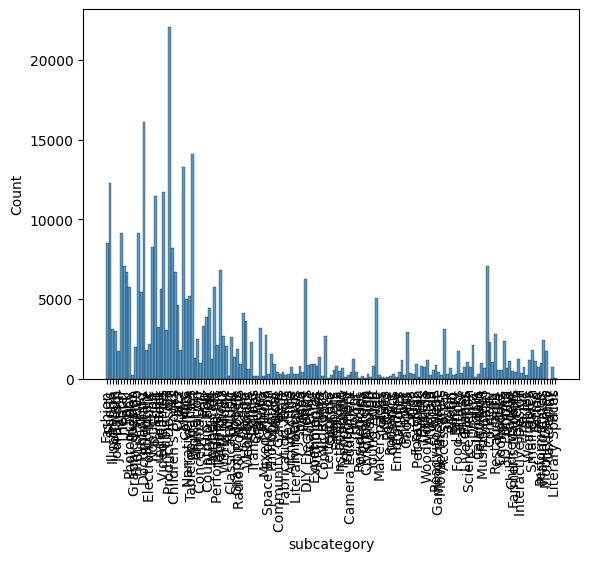

In [20]:
ax = sns.histplot(data=df['subcategory'])
ax.tick_params(axis='x', rotation=90)

In [21]:
df['subcategory'].value_counts(normalize=True)*100
#Too many subcategories, ignore for first model


subcategory
Product Design     5.932725
Documentary        4.322210
Tabletop Games     3.781699
Music              3.563720
Shorts             3.308919
                     ...   
Residencies        0.018546
Letterpress        0.012901
Chiptune           0.009407
Literary Spaces    0.006182
Taxidermy          0.003494
Name: proportion, Length: 159, dtype: float64

<Axes: >

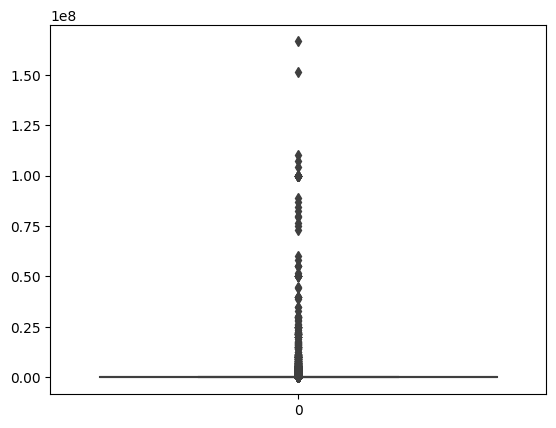

In [22]:
sns.boxplot(data=df['goal'])



In [23]:
zero_goal = df[df['goal'] < 10]
zero_goal

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter
595,Music,Music,United States,2009-09-15 07:12:42,2009-11-16,2,0,0,0,20,61,9,11,3,4
738,Art,Conceptual Art,United States,2009-10-06 11:35:47,2009-10-21,1,144,5,1,54,14,10,10,4,4
1085,Art,Conceptual Art,United States,2009-11-25 07:54:49,2009-12-04,0,100,6,1,39,8,11,12,4,4
1256,Art,Art,United States,2009-12-17 23:57:50,2009-12-26,1,336,8,1,41,8,12,12,4,4
1409,Art,Performance Art,United States,2010-01-09 23:46:08,2010-04-01,1,0,0,0,10,81,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370924,Design,Product Design,United States,2017-11-22 19:52:28,2017-12-09,1,11,1,1,28,16,11,12,4,4
371660,Film & Video,Film & Video,United States,2017-11-29 00:01:03,2017-12-29,1,1,1,0,39,29,11,12,4,4
371829,Music,Music,Canada,2017-11-30 01:27:27,2017-12-30,2,2,1,1,11,29,11,12,4,4
373911,Art,Art,United States,2017-12-18 21:38:26,2017-12-25,1,74,17,0,57,6,12,12,4,4


In [24]:
bins = [-1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 167000000]
label = [1,2,3,4,5,6,7, 8]


df['binned_goal'] = pd.cut(df['goal'], bins = bins, labels=label)

df.head()



,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter,binned_goal
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,0,59,39,4,5,2,2,3
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,0,30,87,4,7,2,3,5
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,1,19,8,4,5,2,2,2
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,1,28,79,4,7,2,3,2
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,0,10,28,4,5,2,2,4


In [25]:
df['goal'].max()

166361391

<Axes: xlabel='binned_goal', ylabel='Count'>

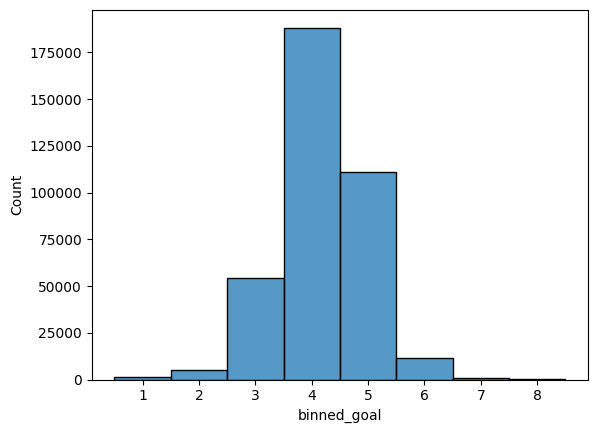

In [26]:
sns.histplot(data=df, x = 'binned_goal')


In [27]:
df[df['binned_goal'].isnull()]

,category,subcategory,country,launched,deadline,goal,pledged,backers,state,name_length,campaign_duration,launched_month,deadline_month,launched_quarter,deadline_quarter,binned_goal


In [28]:
df.isna().sum()

category             0
subcategory          0
country              0
launched             0
deadline             0
goal                 0
pledged              0
backers              0
state                0
name_length          0
campaign_duration    0
launched_month       0
deadline_month       0
launched_quarter     0
deadline_quarter     0
binned_goal          0
dtype: int64

In [29]:
df['backers'].describe()

count    372055.000000
mean        106.980393
std         914.532666
min           0.000000
25%           2.000000
50%          12.000000
75%          57.000000
max      219382.000000
Name: backers, dtype: float64

<Axes: xlabel='backers'>

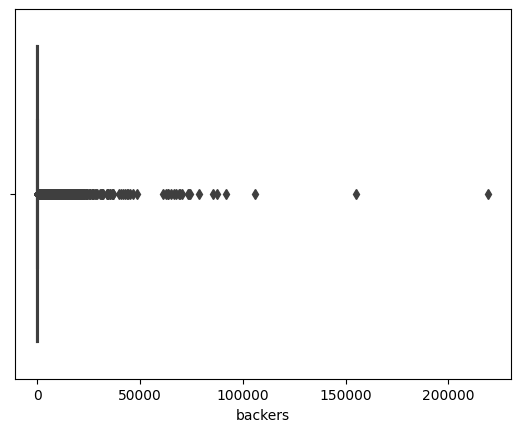

In [30]:
sns.boxplot(data=df, x='backers')

In [31]:
df['backers'].value_counts()

backers
0       51256
1       34530
2       22996
3       15929
4       11954
        ...  
3463        1
7794        1
1657        1
1819        1
2296        1
Name: count, Length: 3952, dtype: int64

In [32]:
df['backers'].max()

219382

In [33]:
bins = [-1, 1000,10_000, 100_000, 300_000]
label = [1,2,3, 4]

df['binned_backers'] = pd.cut(df['backers'], bins = bins, labels=label)

df.head(10)

#sns.countplot
df.isna().sum()

category             0
subcategory          0
country              0
launched             0
deadline             0
goal                 0
pledged              0
backers              0
state                0
name_length          0
campaign_duration    0
launched_month       0
deadline_month       0
launched_quarter     0
deadline_quarter     0
binned_goal          0
binned_backers       0
dtype: int64

<Axes: xlabel='binned_backers', ylabel='Count'>

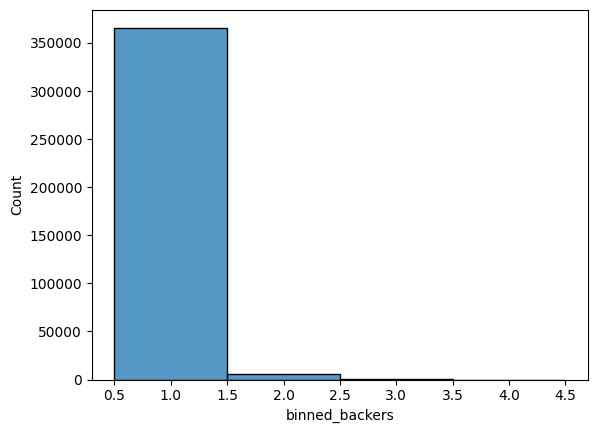

In [34]:
sns.histplot(data=df, x = 'binned_backers')


In [35]:
bins = [-1,1_000,10_000,100_000,1_000_000, 21_000_000]
label = [1,2,3,4,5]

df['binned_pledged'] = pd.cut(df['pledged'], bins = bins, labels=label)

In [36]:
#sns.pairplot(data=df.sample(frac=0.001), hue='state')

In [37]:
df.columns

Index(['category', 'subcategory', 'country', 'launched', 'deadline', 'goal',
       'pledged', 'backers', 'state', 'name_length', 'campaign_duration',
       'launched_month', 'deadline_month', 'launched_quarter',
       'deadline_quarter', 'binned_goal', 'binned_backers', 'binned_pledged'],
      dtype='object')

<Axes: >

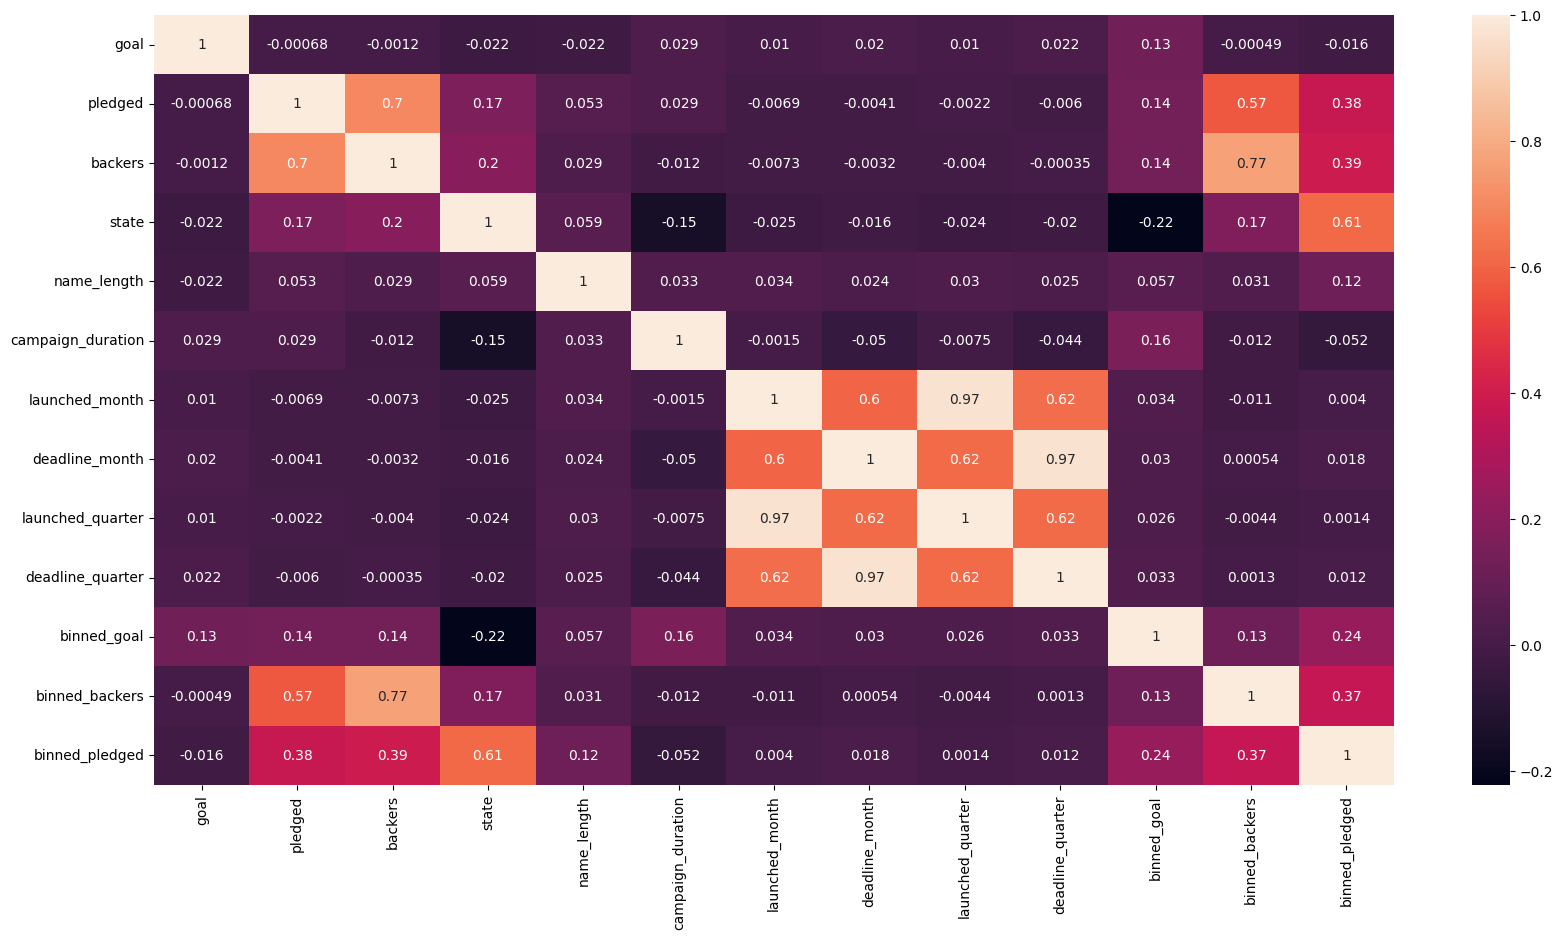

In [38]:

temp = df.drop(columns=['category', 'country', 'launched', 'deadline', 'subcategory'])
corr = temp.sample(frac=0.01).corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)

<Axes: xlabel='name_length', ylabel='Count'>

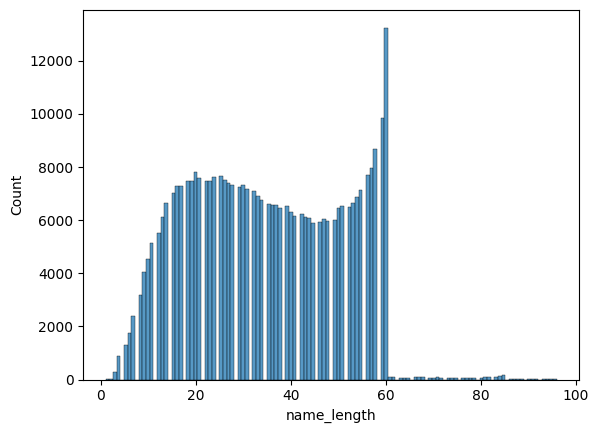

In [39]:
sns.histplot(x=df.name_length)

<Axes: xlabel='binned_pledged', ylabel='Count'>

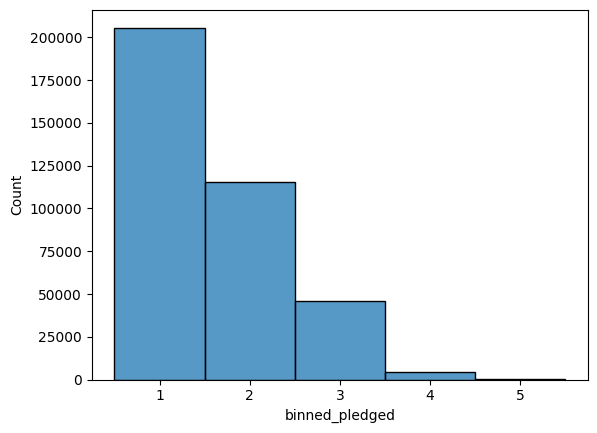

In [40]:
sns.histplot(x=df.binned_pledged)

# Feature Engineering/Preprocessing

In [41]:
features = ['goal','name_length', 'campaign_duration', 'launched_month', 'deadline_month', 'country', 'category']
target = 'state'
X = df[features]
y = df[target]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=RSEED)

In [43]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (297644, 7)
X_test shape:  (74411, 7)
y_train shape:  (297644,)
y_test shape:  (74411,)


In [44]:
num_cols = ['goal'] #, 'name_length', 'campaign_duration', 'launched_month', 'deadline_month']
cat_cols = ['category', 'country']

In [45]:
# num_pipeline = Pipeline([
#     #('scaling', RobustScaler())
#     ('binning', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', random_state=RSEED, subsample=None))
# ])

num_pipeline = Pipeline([
    ('scaling', RobustScaler())

])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first'))
])

In [46]:
fe_transformer = ColumnTransformer([
    ('num_transform', num_pipeline, num_cols),
    ('cat_transform', cat_pipeline, cat_cols)
], remainder='passthrough')

## Baseline Model

In [47]:
# def baseline(X_data):
#     avg_pledge_per_backer = X_data['pledged'] / X_data['backers']
#     return X_data['goal'] <= X_data['backers'] * avg_pledge_per_backer.mean()

In [48]:
# y_train_pred_baseline = baseline(X_train)
# y_train_pred_baseline

In [49]:
# print('Accuracy: ', accuracy_score(y_train, y_train_pred_baseline).round(2))
# print('Recall: ', recall_score(y_train, y_train_pred_baseline).round(2))
# print('Precision: ', precision_score(y_train, y_train_pred_baseline).round(2))
# print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred_baseline).round(2))

In [50]:
# confusion_matrix(y_train, y_train_pred_baseline)

## First simple ML model (Logistic Regression)

In [51]:
model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', LogisticRegression(max_iter=1000))
])

In [52]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['goal']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category', 'country'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [53]:
y_train_pred = model_pipeline.predict(X_train)

In [54]:
print('Accuracy: ', accuracy_score(y_train, y_train_pred).round(2))
print('Recall: ', recall_score(y_train, y_train_pred).round(2))
print('Precision: ', precision_score(y_train, y_train_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred).round(2))


Accuracy:  0.67
Recall:  0.28
Precision:  0.59
ROC-AUC:  0.59


In [55]:
confusion_matrix(y_train, y_train_pred)

array([[169170,  21393],
       [ 76686,  30395]], dtype=int64)

In [56]:
cross_val_score(model_pipeline, X_train, y_train, cv=5, n_jobs=-1)

array([0.67016076, 0.67054713, 0.66942163, 0.67027835, 0.67163352])

## Stacking model

Decision tree has 1601 nodes with maximum depth 10.


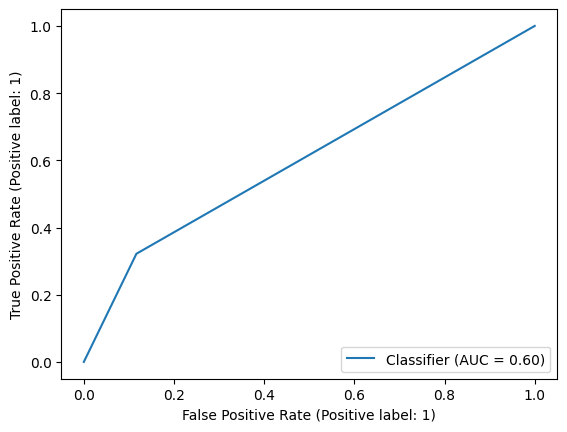

In [81]:
# Test decsision tree as base model
tree = DecisionTreeClassifier(max_depth=10)

tree_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', tree)
])

tree_pipeline.fit(X_train, y_train)

print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

y_train_pred = tree_pipeline.predict(X_train)

tree_roc = RocCurveDisplay.from_predictions(y_train,y_train_pred)


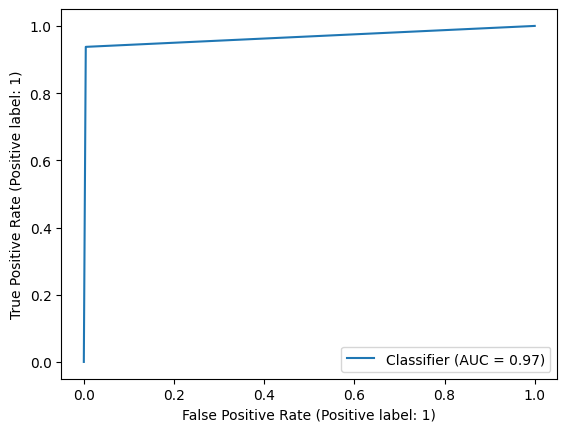

In [104]:
# Test knn as base model
knn = KNeighborsClassifier(weights='distance', n_neighbors=10)

knn_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', knn)
])

knn_pipeline.fit(X_train, y_train)
y_train_pred = knn_pipeline.predict(X_train)

knn_roc = RocCurveDisplay.from_predictions(y_train, y_train_pred)


Accuracy:  0.97
Recall:  0.94
Precision:  0.99
ROC-AUC:  0.97


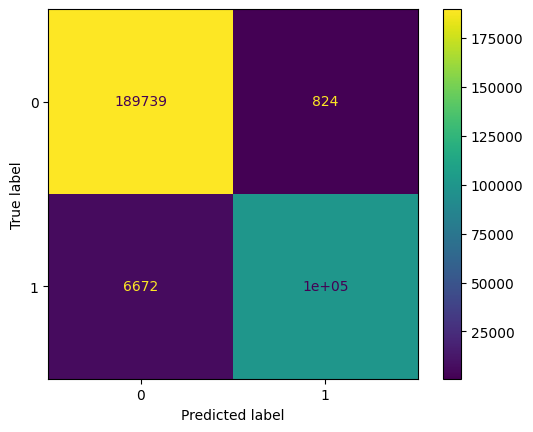

In [105]:
print('Accuracy: ', accuracy_score(y_train, y_train_pred).round(2))
print('Recall: ', recall_score(y_train, y_train_pred).round(2))
print('Precision: ', precision_score(y_train, y_train_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred).round(2))

cm = confusion_matrix(y_train, y_train_pred, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot()

plt.show()

In [109]:
cross_val_score(knn_pipeline, X_train, y_train, cv=5, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.3min remaining: 17.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


array([0.630701  , 0.63194409, 0.63093618, 0.63229686, 0.63119876])

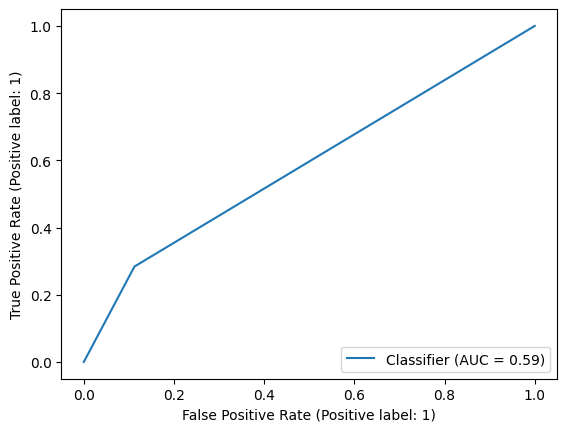

In [86]:
# Test logistic regression as base model
logreg = LogisticRegression(max_iter=1000)

logreg_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', logreg)
])

logreg_pipeline.fit(X_train, y_train)
y_train_pred = logreg_pipeline.predict(X_train)

logreg_roc = RocCurveDisplay.from_predictions(y_train,y_train_pred)


In [60]:
#Stacking is an ensemble machine learning strategy that combines the prediction of several base models 
#and uses a metal model (e.g. logistic regression) to generate a final prediciton



base_models = [('logreg', LogisticRegression(max_iter=1000)),
               ('knn', KNeighborsClassifier(weights='distance', n_neighbors=10)),
               ('tree', DecisionTreeClassifier(max_depth=10))]
meta_model = LogisticRegression()

stack = StackingClassifier(estimators=base_models, final_estimator=meta_model, verbose=3, stack_method='predict', n_jobs=-1)
stack

StackingClassifier(estimators=[('logreg', LogisticRegression(max_iter=1000)),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=10,
                                                     weights='distance')),
                               ('tree', DecisionTreeClassifier(max_depth=10))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict', verbose=3)

In [61]:
#Include hyperparameter optimization
param_grid = {
    'logreg__max_iter': [1000],
    'tree__criterion': ['gini'],  # Hyperparameters for decision tree
    'tree__max_depth': [10, 20],  # Hyperparameters for decision tree
    'knn__n_neighbors': [5, 10, 15],# Hyperparameters for knn
    #'knn__weights': ['uniform', 'distance'], # Hyperparameters for knn
    #'final_estimator__C': [0.1, 1, 10],  # Hyperparameters for Logistic Regression (meta-learner)
    'final_estimator__penalty': ['l2'], # Hyperparameters for Logistic Regression (meta-learner)
}

grid_search = GridSearchCV(estimator=stack, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

In [ ]:
stack_model_pipeline = Pipeline([
    ('preprocessing', fe_transformer),
    ('model', stack)#change stack to grid_search for hyperparameter optimization
])
stack_model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['goal']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category', 'country'])])),
                ('model',
                 StackingClassifier(estimators=[('logreg',
                                                 LogisticRegression(max_iter=1000)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=10,
                                                                      weights='distance')),
                                                ('tree',
                                                 DecisionTreeClassifier(max_depth=10))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict',
                                    verbose=3))])

In [65]:
X_train_sub = X_train.iloc[1:10_000]
y_train_sub = y_train.iloc[1:10_000]

In [72]:
stack_model_pipeline.fit(X_train_sub, y_train_sub)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['goal']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category', 'country'])])),
                ('model',
                 StackingClassifier(estimators=[('logreg',
                                                 LogisticRegression(max_iter=1000)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=10,
                                                                      weights='distance')),
                                                ('tree',
                                                 DecisionTreeClassifier(max_depth=10))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict',
                                    verbose=3))])

In [60]:
#grid_search.best_estimator_


In [89]:
# best_model_pipeline = Pipeline([
#     ('preprocessing', fe_transformer),
#     ('model', grid_search.best_estimator_)
# ])

# best_model_pipeline.fit(X_train, y_train)

# y_train_pred = best_model_pipeline.predict(X_train)

In [ ]:
# print('Accuracy: ', accuracy_score(y_train, y_train_pred).round(2))
# print('Recall: ', recall_score(y_train, y_train_pred).round(2))
# print('Precision: ', precision_score(y_train, y_train_pred).round(2))
# print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred).round(2))

Accuracy:  0.7
Recall:  0.35
Precision:  0.64
ROC-AUC:  0.62


In [77]:
#cross_val_score(stack, fe_transformer.fit_transform(X_train_subset), y_train_subset, cv=5, n_jobs=-1, scoring='roc_auc')

In [87]:
y_train_pred = stack_model_pipeline.predict(X_train_sub)


In [88]:
print('Accuracy: ', accuracy_score(y_train_sub, y_train_pred).round(2))
print('Recall: ', recall_score(y_train_sub, y_train_pred).round(2))
print('Precision: ', precision_score(y_train_sub, y_train_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_train_sub, y_train_pred).round(2))

Accuracy:  0.71
Recall:  0.28
Precision:  0.73
ROC-AUC:  0.61


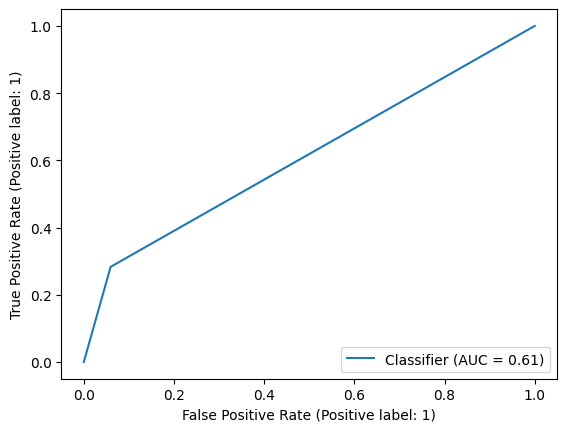

In [93]:
stack_roc = RocCurveDisplay.from_predictions(y_train_sub,y_train_pred)


In [69]:
confusion_matrix(y_train, y_train_pred)

array([[170030,  20533],
       [ 65659,  41422]], dtype=int64)

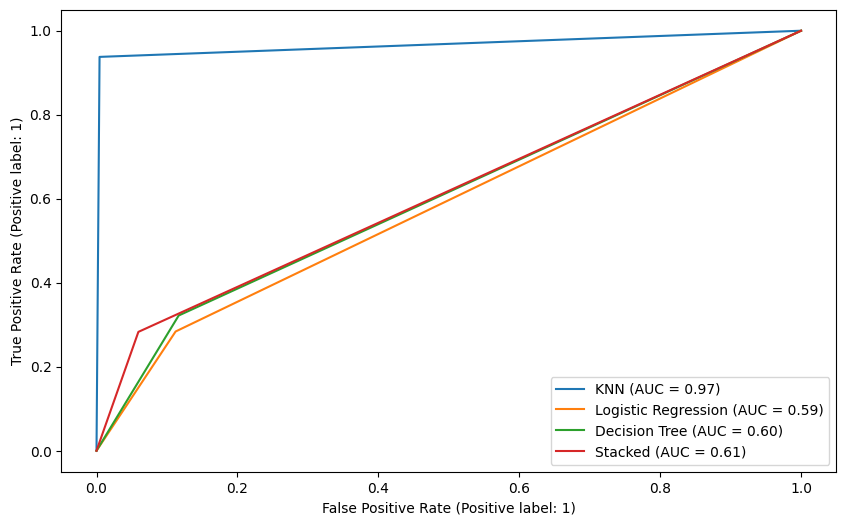

In [ ]:
# Plot roc auc of base models and meta learner

plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes
knn_roc.plot(ax=ax, name='KNN')
logreg_roc.plot(ax=ax, name='Logistic Regression')
tree_roc.plot(ax=ax, name='Decision Tree')
stack_roc.plot(ax=ax, name='Stacked')


## ML with test set

In [ ]:
#Test
stack_model_pipeline.fit(X_test, y_test)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transform',
                                                  Pipeline(steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    random_state=75,
                                                                                    subsample=None))]),
                                                  ['pledged', 'backers']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category', 'country'])])),
                ('model',
                 StackingClassifier(cv=5,
                                    estimators=[('logreg',
                                                 LogisticRegression(max_iter=1000)),
                                                ('knn', KNeighborsClassifier()),
                                                ('tree',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LogisticRegression(),
                                    verbose=3))])

In [247]:
y_test_pred = stack_model_pipeline.predict(X_test)

In [ ]:
print('Accuracy: ', accuracy_score(y_test, y_test_pred).round(2))
print('Recall: ', recall_score(y_test, y_test_pred).round(2))
print('Precision: ', precision_score(y_test, y_test_pred).round(2))
print('ROC-AUC: ', roc_auc_score(y_test, y_test_pred).round(2))

Accuracy:  0.87
Recall:  0.82
Precision:  0.83
ROC-AUC:  0.86


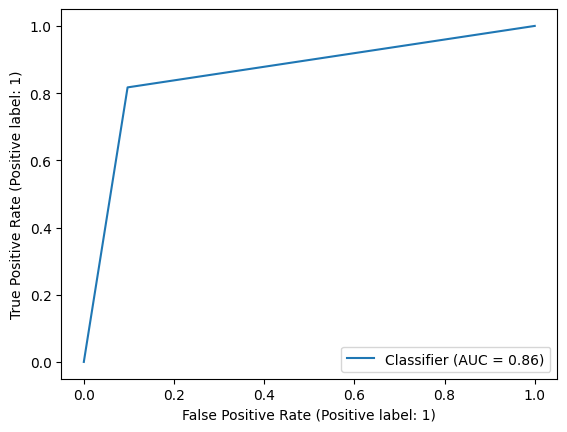

In [ ]:
RocCurveDisplay.from_predictions(y_test,y_test_pred)


In [250]:
confusion_matrix(y_test, y_test_pred)

array([[43017,  4624],
       [ 4897, 21873]], dtype=int64)